In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn import cross_validation
import random
import math
from pnl_metrics import *
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
import scipy as scipy
import math as math


from features import *
from labels import *
from column_names import *
from computing_returns import *
from cross_sectional_MR_naive_plus_ML import *

from EnsembleClassifier import *#class for ensembles (lo baje de internet hace mucho)


%matplotlib inline 
%load_ext autoreload
%autoreload 2

C:\Users\hipo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#---------------------------------------------------------------
#-------------LOADING DATA FROM DATABASE------------------------
#---------------------------------------------------------------

country='canada'

#database: one file for each feature (open, high, low, close, volume)
database_close='Database/' + country + '/' + country +  '_close.csv'
database_high='Database/' + country + '/' + country +  '_high.csv'
database_low='Database/' + country + '/' + country +  '_low.csv'
database_volume='Database/' + country + '/' + country +  '_volume.csv'


stock_list_file='Database/' + country + '/' + country +  '_stocks.csv'

#_____________LOADING THE DATA________________

pd.options.display.float_format = '{:,.2f}'.format#format to display

#List of stocks
stock_list=pd.read_csv(stock_list_file)#list of stocks

#cuando guardo manualmente los archivos de database el format de la fechas se arruina -->tengo q usar el parser de abajo
#dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
#date_parser=dateparse,-->dentro del pd.read_csv

#Prices
dataClose = pd.read_csv(database_close, parse_dates=['Date'],   
                        index_col=0, dayfirst = True)#one column for each stock-->Indexed by dates (column 0=stock 0) 

dataHigh = pd.read_csv(database_high, parse_dates=['Date'],   
                        index_col=0, dayfirst = True)#one column for each stock-->Indexed by dates (column 0=stock 0) 

dataLow = pd.read_csv(database_low, parse_dates=['Date'],   
                        index_col=0, dayfirst = True)#one column for each stock-->Indexed by dates (column 0=stock 0)

dataVolume = pd.read_csv(database_volume, parse_dates=['Date'],   
                        index_col=0, dayfirst = True)#one column for each stock-->Indexed by dates (column 0=stock 0) 

DEFINING MODELS AND BACKTESTING PERIODS

In [5]:
#definition of Models/Classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

bdt_real = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=600,learning_rate=1)
gnb = MultinomialNB()
cl_RF=RandomForestClassifier(random_state=1)
cl_LR=LogisticRegression(random_state=1)
clf_svm = svm.SVC(decision_function_shape='ovo', probability=True)

cl_production=cl_RF

#ENSEMBLE 2: 4 CLASSIFIERS
#cl_production = EnsembleClassifier(clfs=[bdt_real, clf_svm,cl_RF,cl_LR], weights=[1,1,1,1])
#cl_production = EnsembleClassifier(clfs=[clf_svm,cl_RF,cl_LR], weights=[1,1,1])

In [6]:
#-----------------Parameters------------------------#
#----Study Window-----
#Used to reduce data (window needs to be larger than backtesting period to allow for features collection)
data_start='2013-01-01'
data_end='2017-06-27'


backtest_start='2016-01-01'
backtest_end='2017-06-26'
#"train window" is the number of days used to train the model 
#then the trained model is applied during the following "test window"-->rolling system
train_window=80
test_window=5

SELECTING GROUP OF STOCKS

In [7]:
#stock_ids=[0,1,2]
option=1

In [14]:
list_of_groups = pd.read_csv('groups3.csv')#one column for each stock-->Indexed by dates (column 0=stock 0) 


In [15]:
#index_=range(11)
index_=['PnL','CAGR','Sharpe Ratio','Max Drawdown','Calmar','Max Drawdown Duration','Traded Days %',
              'Winner Days %','Avg Trade','Avg Win', 'Avg Loss']
columns_=range(list_of_groups.shape[0])
#columns_=strat1.results_table_df.index
results_table=pd.DataFrame(index=index_,columns=columns_)

In [ ]:
for i in range(list_of_groups.shape[0]):
    stock_ids=list(eval(list_of_groups.ix[i,0]))
    strat1=cross_sectional_MR_naive_plus_ML(dataClose,dataHigh,dataLow,dataVolume,cl_production, stock_list,
                 data_start,data_end,backtest_start,backtest_end, train_window, test_window,
                 stock_ids, option)
    strat1.cleaning_data()
    strat1.features()
    strat1.labels()
    strat1.cleaning_features_and_labels()
    strat1.training_and_predicting()
    strat1.computing_returns()
    #saving results
    results_table.ix[:,i]=strat1.results_table_df.ix[:,0]

In [13]:
results_table

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
PnL,0.16,0.39,0.37,0.30,0.28,0.27,0.27,0.81,0.25,0.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAGR,0.13,0.33,0.32,0.26,0.24,0.23,0.23,0.67,0.21,0.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sharpe Ratio,1.19,2.71,2.96,2.29,2.02,1.19,1.91,2.17,1.01,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Drawdown,0.06,0.04,0.04,0.07,0.05,0.11,0.07,0.14,0.20,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Calmar,2.24,7.72,7.26,3.42,5.21,2.04,3.29,4.82,1.08,3.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max Drawdown Duration,84,32,47,58,16,241,12,62,258,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Traded Days %,0.57,0.61,0.60,0.54,0.53,0.43,0.56,0.55,0.51,0.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Winner Days %,0.55,0.60,0.59,0.58,0.56,0.52,0.54,0.58,0.52,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Trade,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg Win,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
results_table.to_csv('results.csv')

In [36]:
strat1=cross_sectional_MR_naive_plus_ML(dataClose,dataHigh,dataLow,dataVolume,cl_production, stock_list,
                 data_start,data_end,backtest_start,backtest_end, train_window, test_window,
                 stock_ids, option)
strat1.cleaning_data()
strat1.features()
strat1.labels()
strat1.cleaning_features_and_labels()
strat1.training_and_predicting()
strat1.computing_returns()

C:\Users\hipo\Dropbox\Trading\Code\Cross-sectional MR Naive plus ML\cross_sectional_MR_naive_plus_ML.py:187: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  #High
C:\Users\hipo\Dropbox\Trading\Code\Cross-sectional MR Naive plus ML\cross_sectional_MR_naive_plus_ML.py:191: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  #Low
C:\Users\hipo\Dropbox\Trading\Code\Cross-sectional MR Naive plus ML\cross_sectional_MR_naive_plus_ML.py:195: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  #Volume
C:\Users\hipo\Dropbox\Trading\Code\Cross-sectional MR Naive plus ML\cross_sectional_MR_naive_plus_ML.py:199: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  
C:\Users\hipo\Dropbox\Trading\Code\Cross-sectional MR Naive plus ML\features.py:139: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(span=5,min_periods=0,adjust=True,ignore_na=False).mean()
  ema=pd.ewma(dat

In [37]:
pd.options.display.float_format = '{:,.4f}'.format
strat1.results_table_df

,PnL Metrics
PnL,-0.4588
CAGR,-0.1407
Sharpe Ratio,-0.2594
Max Drawdown,1.1975
Calmar,-0.1175
Max Drawdown Duration,0
Traded Days %,0.5539
Winner Days %,0.4956
Avg Trade,-0.0008
Avg Win,0.0257


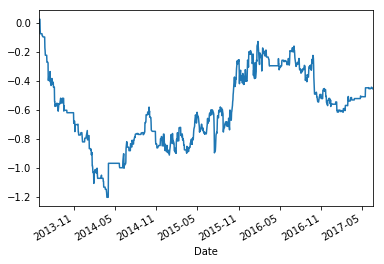

In [38]:
(strat1.pnl_daily.cumsum()).plot()

In [39]:
pd.options.display.float_format = '{:,.4f}'.format
strat1.results_table_df

,PnL Metrics
PnL,-0.4588
CAGR,-0.1407
Sharpe Ratio,-0.2594
Max Drawdown,1.1975
Calmar,-0.1175
Max Drawdown Duration,0
Traded Days %,0.5539
Winner Days %,0.4956
Avg Trade,-0.0008
Avg Win,0.0257


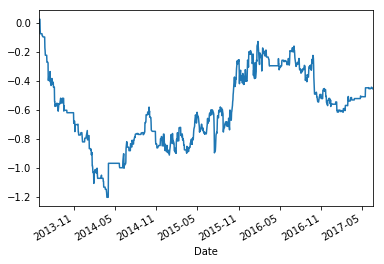

In [40]:
(strat1.pnl_daily.cumsum()).plot()

In [16]:
strat1.pnl_daily.sum()

0.18186969220379645

In [17]:
strat1.pnl_daily.to_csv('pnl2.csv')